In [8]:
import pickle
import numpy as np
import os
from scipy.misc import imread, imresize, imshow
import matplotlib.pyplot as plt
import datetime

Функции для чтения набора данных

In [2]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [3]:
Xtr, Ytr, Xte, Yte = load_CIFAR10('../data/cifar-10-batches-py/') # a magic function we provide
# flatten out all images to be one-dimensional
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

Попытка вывести картинку на экран

In [4]:
im = np.reshape(Xtr[1], (32,32,3), order='F')

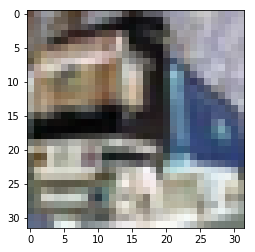

In [5]:
plt.imshow(im)
plt.show()

Nearest Neighbor Classifier

In [35]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y

    def predict(self, X):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # lets make sure that the output type matches the input type
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

        # loop over all test rows
        for i in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1) # L1-reg
            distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1)) # L2-reg
            min_index = np.argmin(distances) # get the index with smallest distance
            Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

        return Ypred

Предсказания на NN

In [36]:
nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(Xtr_rows, Ytr) # train the classifier on the training images and labels
Yte_predict = nn.predict(Xte_rows) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print('accuracy: %f' % ( np.mean(Yte_predict == Yte) ))

accuracy: 0.385900


Предсказания на kNN

In [6]:
class kNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        num_test = X.shape[0]
        # lets make sure that the output type matches the input type
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

        # loop over all test rows
        for i in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1) # L1-reg
            #distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1)) # L2-reg
            indexes = np.argpartition(distances, k)[:k] # get the index with smallest distance
            Ypred[i] = np.argmax(np.bincount(self.ytr[indexes])) # predict the label of the nearest example

        return Ypred

In [9]:
Xval_rows = Xtr_rows[:1000, :] # take first 1000 for validation
Yval = Ytr[:1000]
Xtr_rows = Xtr_rows[1000:, :] # keep last 49,000 for train
Ytr = Ytr[1000:]

# find hyperparameters that work best on the validation set
validation_accuracies = []
for k in [1, 3, 5, 10, 20, 50, 100]:
  
    # use a particular value of k and evaluation on validation data
    knn = kNearestNeighbor()
    knn.train(Xtr_rows, Ytr)
    # here we assume a modified NearestNeighbor class that can take a k as input
    Yval_predict = knn.predict(Xval_rows, k = k)
    acc = np.mean(Yval_predict == Yval)
    print('accuracy: %f with k = %d' % (acc, k))
    print (datetime.datetime.now())
    # keep track of what works on the validation set
    validation_accuracies.append((k, acc))

accuracy: 0.398000 with k = 1
2017-11-17 21:12:07.168835
accuracy: 0.398000 with k = 3
2017-11-17 21:26:00.229978
accuracy: 0.392000 with k = 5
2017-11-17 21:39:54.749618
accuracy: 0.403000 with k = 10
2017-11-17 21:53:46.815777
accuracy: 0.401000 with k = 20
2017-11-17 22:07:42.939102
accuracy: 0.375000 with k = 50
2017-11-17 22:21:42.765646
accuracy: 0.370000 with k = 100
2017-11-17 22:35:39.049745
